In [252]:
import numpy as np
from Utils.discrete_family import discrete_family
from CART import RegressionTree
from scipy.interpolate import interp1d
from scipy.stats import multivariate_normal as mvn

# A deterministic tree

In [274]:
import numpy as np

class TreeNode_:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None):
        self.feature_index = feature_index  # Index of the feature to split on
        self.threshold = threshold  # Threshold value to split on
        self.left = left  # Left child node
        self.right = right  # Right child node
        self.value = value  # Value for leaf nodes (mean of target values)

class RegressionTree_:
    def __init__(self, min_samples_split=2, max_depth=float('inf')):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.root = None

    def fit(self, X, y):
        self.root = self._build_tree(X, y)

    def _build_tree(self, X, y, depth=0):
        num_samples, num_features = X.shape
        if num_samples >= self.min_samples_split and depth <= self.max_depth:
            best_split = self._get_best_split(X, y, num_features)
            if best_split["gain"] > 0:
                left_subtree = self._build_tree(best_split["X_left"], best_split["y_left"], depth + 1)
                right_subtree = self._build_tree(best_split["X_right"], best_split["y_right"], depth + 1)
                return TreeNode_(feature_index=best_split["feature_index"], threshold=best_split["threshold"], 
                                left=left_subtree, right=right_subtree)
        leaf_value = self._calculate_leaf_value(y)
        return TreeNode_(value=leaf_value)

    def _get_best_split(self, X, y, num_features):
        best_split = {}
        max_gain = -float('inf')
        for feature_index in range(num_features):
            feature_values = X[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            for threshold in possible_thresholds:
                X_left, y_left, X_right, y_right = self._split(X, y, feature_index, threshold)
                if len(X_left) > 0 and len(X_right) > 0:
                    curr_gain = self._calculate_information_gain(y, y_left, y_right)
                    if curr_gain > max_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["X_left"] = X_left
                        best_split["y_left"] = y_left
                        best_split["X_right"] = X_right
                        best_split["y_right"] = y_right
                        best_split["gain"] = curr_gain
                        max_gain = curr_gain
        return best_split

    def _split(self, X, y, feature_index, threshold):
        left_mask = X[:, feature_index] <= threshold
        right_mask = X[:, feature_index] > threshold
        return X[left_mask], y[left_mask], X[right_mask], y[right_mask]

    def _calculate_information_gain(self, y, y_left, y_right):
        var_total = np.var(y) * len(y)
        var_left = np.var(y_left) * len(y_left)
        var_right = np.var(y_right) * len(y_right)
        return var_total - (var_left + var_right)

    def _calculate_leaf_value(self, y):
        return np.mean(y)

    def predict(self, X):
        return np.array([self._predict(sample, self.root) for sample in X])

    def _predict(self, sample, tree):
        if tree.value is not None:
            return tree.value
        feature_value = sample[tree.feature_index]
        if feature_value <= tree.threshold:
            return self._predict(sample, tree.left)
        else:
            return self._predict(sample, tree.right)

In [275]:
class TreeNode:
    def __init__(self, feature_index=None, threshold=None, pos=None,
                 left=None, right=None, value=None, prev_branch=None,
                 prev_node=None, membership=None, depth=0, which=None,
                 randomization=None):
        self.feature_index = feature_index  # Index of the feature to split on
        self.threshold = threshold  # Threshold value to split on
        self.pos = pos # Position (the ascending order) of the split value
        self.left = left  # Left child node
        self.right = right  # Right child node
        self.value = value  # Value for leaf nodes (mean of target values)
        self.prev_branch = prev_branch # List of (j, s, e) depicting a previous branch
        self.prev_node = prev_node
        self.membership = membership
        self.depth = depth
        self.randomization = randomization

class RegressionTree:
    def __init__(self, min_samples_split=2, max_depth=float('inf')):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.root = None

    def fit(self, X, y):
        self.X = X
        self.y = y
        self.n = X.shape[0]
        self.root = self._build_tree(X, y)
    
    def _build_tree(self, X, y, depth=0, membership=None, 
                    prev_branch=None):
        """
        A recursive private function to build the tree 
        by repeatedly splitting 
        :param X: the covariates of the previous sub-region
        :param y: the response of the previous sub-region
        :param depth: depth of the previous split
        :return: a node characterizing this split and fitted value
        """
        num_samples, num_features = X.shape
        if depth == 0:
            membership = np.ones((num_samples,))
        else:
            assert membership is not None
        
        if prev_branch is None:
            prev_branch = []
            #print("pbc:", prev_branch)
            
        if num_samples >= self.min_samples_split and depth <= self.max_depth:
            best_split = self._get_best_split(X, y, num_features)
            feature_idx = best_split["feature_index"]
            threshold = best_split["threshold"]
            pos = best_split["position"]
            left_mbsp = self.X[:,feature_idx] <= threshold
            right_mbsp = self.X[:,feature_idx] > threshold
            left_mbsp = left_mbsp * membership # n x 1 logical vector
            right_mbsp = right_mbsp * membership # n x 1 logical vector
            # if best_split["gain"] > 0:
            left_prev_branch = prev_branch.copy()
            left_prev_branch.append([feature_idx, pos, 0])
            right_prev_branch = prev_branch.copy()
            right_prev_branch.append([feature_idx, pos, 1])
            #print(left_prev_branch)
            #print(right_prev_branch)
            left_subtree \
                = self._build_tree(best_split["X_left"],
                                   best_split["y_left"], 
                                   depth + 1, 
                                   membership=left_mbsp,
                                   prev_branch=left_prev_branch)
            right_subtree \
                = self._build_tree(best_split["X_right"],
                                   best_split["y_right"], 
                                   depth + 1,
                                   membership=right_mbsp,
                                   prev_branch=right_prev_branch)
            return TreeNode(feature_index=best_split["feature_index"],
                            threshold=best_split["threshold"],
                            left=left_subtree, right=right_subtree,
                            membership=membership, depth=depth,
                            randomization=best_split["randomization"],
                            prev_branch=prev_branch)
        leaf_value = self._calculate_leaf_value(y)
        return TreeNode(value=leaf_value, membership=membership,
                        depth=depth)

    def _get_best_split(self, X, y, num_features, sd_rand=1):
        """
        Input (X, y) of a (potentially sub-)region, return information about 
        the best split on this regions
        Assuming no ties in features
        :param X: the (sub-)region's covariates
        :param y: the (sub-)region's response
        :param num_features: dimension of X
        :return: a dictionary containing 
                {split_feature_idx, (numerical) splitting_threshold,
                split_position, left_sub_region, right_sub_region,
                gain}
        """
        best_split = {}
        min_loss = float('inf')
        num_sample = X.shape[0]
        randomization = np.zeros((num_sample-1, num_features))
        
        for feature_index in range(num_features):
            feature_values = X[:, feature_index]
            feature_values_sorted = feature_values.copy()
            feature_values_sorted.sort()
            for i in range(len(feature_values_sorted)-1):
                threshold = feature_values_sorted[i]
                X_left, y_left, X_right, y_right = self._split(X, y, feature_index, threshold)
                if len(X_left) > 0 and len(X_right) > 0:
                    omega = np.random.normal(scale=sd_rand)
                    randomization[i, feature_index] = omega
                    loss = self._calculate_loss(y_left, y_right, omega)
                    if loss < min_loss:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["position"] = i
                        best_split["X_left"] = X_left
                        best_split["y_left"] = y_left
                        best_split["X_right"] = X_right
                        best_split["y_right"] = y_right
                        best_split["loss"] = loss
                        best_split["randomization"] = randomization
                        #best_split[""]
                        min_loss = loss
        return best_split

    def _split(self, X, y, feature_index, threshold):
        left_mask = X[:, feature_index] <= threshold
        right_mask = X[:, feature_index] > threshold
        return X[left_mask], y[left_mask], X[right_mask], y[right_mask]

    def _calculate_information_gain(self, y, y_left, y_right):
        var_total = np.var(y) * len(y)
        var_left = np.var(y_left) * len(y_left)
        var_right = np.var(y_right) * len(y_right)
        return var_total - (var_left + var_right)
    
    def _calculate_loss(self, y_left, y_right, randomization):
        n1 = len(y_left)
        n2 = len(y_right)
        loss = - n1 * np.mean(y_left)**2 - n2 * np.mean(y_right)**2 + randomization
        
        return loss
    
    # 
    def _calculate_leaf_value(self, y):
        """
        :param y: the response of the previous sub-region
        :return: the mean of the region
        """
        return np.mean(y)

    def predict(self, X):
        """
        :param X: the test dataset
        :return: fitted values
        """
        return np.array([self._predict(sample, self.root) for sample in X])

    def _predict(self, sample, tree):
        """
        Recursively searching the tree for the surrounding region of `sample`
        :param sample: the input covariates
        :param tree: the trained tree
        :return: fitted y value of `sample`
        """
        if tree.value is not None:
            return tree.value
        feature_value = sample[tree.feature_index]
        if feature_value <= tree.threshold:
            return self._predict(sample, tree.left)
        else:
            return self._predict(sample, tree.right)
    
    def compute_log_ref_measure(self, node, grid, nuisance):
        prev_branch = node.prev_branch
        node = self.root
        ## TODO: Move the node according to branch when evaluating integrals
        X = self.X[node.membership.astype(bool)]
        ref_measure = []
        
        for g in grid:
            y = g + nuisance
            y_left = self.y[node.left.membership.astype(bool)]
            y_right = self.y[node.left.membership.astype(bool)]
            optimal_loss = self._calculate_loss(y_left, y_right, 
                                                randomization=0)
            randomization = node.randomization
            S_total, J_total = randomization.shape
            implied_mean = []
            
            # TODO: Add a layer to account for depth of the tree
            for j in range(J_total):
                feature_values = X[:, j]
                feature_values_sorted = feature_values.copy()
                feature_values_sorted.sort()
                for s in range(S_total-1):
                    threshold = feature_values_sorted[s]
                    X_left, y_left, X_right, y_right = self._split(X, y, j, threshold)
                    implied_mean_s_j = self._calculate_loss(y_left, y_right, randomization=0)
                    implied_mean.append(implied_mean_s_j)   
            
            implied_mean = np.array(implied_mean)
            implied_mean = optimal_loss - implied_mean
            n_opt = len(implied_mean)
            implied_cov = np.ones((n_opt, n_opt)) + np.eye(n_opt)
            sel_prob = mvn(mean=implied_mean, cov=implied_cov).cdf(np.zeros(n_opt))
            ref_measure.append(np.log(sel_prob))
        
        return np.array(ref_measure)
    
    def log_gaussian_weight(self, x):
        ...
        #return 
        
    def split_inference(self, node, ngrid = 10000, ncoarse=100, 
                        level=0.9):
        """
        Inference for a split of a node 
        :param node: the node whose split is of interest
        :return: p-values for difference in mean 
        """
        # First determine the projection direction
        left_membership = node.left.membership
        right_membership = node.right.membership
        contrast = left_membership / np.sum(left_membership) - right_membership / np.sum(right_membership)
        
        observed_target = contrast @ self.y
        nuisance = self.y - contrast @ contrast.T @ self.y / (np.linalg.norm(contrast)**2)

        stat_grid = np.linspace(-10, 10, num=ngrid)
    
        if ncoarse is not None:
            coarse_grid = np.linspace(-10, 10, ncoarse)
            eval_grid = coarse_grid
        else:
            eval_grid = stat_grid
        
        # Evaluate reference measure (selection prob.) over stat_grid
        ref = self.compute_log_ref_measure(node, eval_grid, nuisance)
    
        if ncoarse is None:
            logWeights = np.zeros((ngrid,))
            for g in range(ngrid):
                # Evaluate the log pdf as a sum of (log) gaussian pdf 
                # and (log) reference measure
                # TODO: Check if the original exp. fam. density is correct
                logWeights[g] = (
                        - 0.5 * (self.stat_grid[g] - observed_target) ** 2 / np.linalg.norm(contrast)**2 + self.log_gaussian_pdf(eval_grid[g]) 
                        + ref[g])
            # normalize logWeights
            logWeights = logWeights - np.max(logWeights)
            condl_density = discrete_family(eval_grid,
                                           np.exp(logWeights),
                                           logweights=logWeights)
        else:
            # print("Coarse grid")
            approx_fn = interp1d(eval_grid,
                                 ref,
                                 kind='quadratic',
                                 bounds_error=False,
                                 fill_value='extrapolate')
            grid = np.linspace(-10, 10, num=ngrid)
            logWeights = np.zeros((ngrid,))
            for g in range(ngrid):
                # TODO: Check if the original exp. fam. density is correct
                logWeights[g] = (
                        - 0.5 * (self.stat_grid[g] - observed_target) ** 2 / np.linalg.norm(contrast)**2 + self.log_gaussian_pdf(eval_grid[g]) 
                        + approx_fn(grid[g]))
    
            # normalize logWeights
            logWeights = logWeights - np.max(logWeights)
            
            condl_density = discrete_family(grid, np.exp(logWeights),
                                           logweights=logWeights)
        
        
        if np.isnan(logWeights).sum() != 0:
            print("logWeights contains nan")
        elif (logWeights == np.inf).sum() != 0:
            print("logWeights contains inf")
        # TODO: uncomment
        elif (np.asarray(ref) == np.inf).sum() != 0:
            print("ref contains inf")
        elif (np.asarray(ref) == -np.inf).sum() != 0:
            print("ref contains -inf")
        elif np.isnan(np.asarray(ref)).sum() != 0:
            print("ref contains nan")
    
        interval = (condl_density.equal_tailed_interval
                        (observed=contrast.T @ self.Y,
                         alpha=1-level))
        if np.isnan(interval[0]) or np.isnan(interval[1]):
            print("Failed to construct intervals: nan")
    
        pivot = condl_density.ccdf(theta=0)
    
        return pivot, interval[0], interval[1]
            
    
    def print_branches(self, node=None, start=True, depth=0):
        """
        Recursively printing (with proper indentation denoting depth) the tree
        :param node: the node to be printed
        :param start: a logic flag for whether the node is the root
        :param depth: depth of a node to be printed
        """
        if start:
            node = self.root
        if node is None:
            return
        if node.left or node.right:
            print("\t"*depth, "j:", node.feature_index)
            print("\t"*depth, "threshold:", node.threshold)
            if node.left and node.right:
                print("\t"*depth, "left:")
                self.print_branches(node.left, start=False, depth=depth+1)
                print("\t"*depth, "right:")
                self.print_branches(node.right, start=False, depth=depth+1)
            elif node.right:
                print("\t"*depth, "left:")
                self.print_branches(node.right, start=False, depth=depth+1)
            else:
                print("\t"*depth, "right:")
                self.print_branches(node.left, start=False, depth=depth+1)
        return 

In [276]:
# Sample data
X = np.array([[1,1.5], [2.8, 0.8], [1.2, 2.7], [3, 3]])
y = np.array([-1, 1, 5, 6])

# Create and train the regression tree
reg_tree = RegressionTree(min_samples_split=2, max_depth=3)
reg_tree.fit(X, y)

# Make predictions
predictions = reg_tree.predict(X)
print(predictions)

[-1.  1.  5.  6.]


In [277]:
contrast = np.array([1,1,-1,-1])
nuisance = y - np.linalg.outer(contrast,contrast) @ y / (np.linalg.norm(contrast)**2)

In [278]:
contrast = np.array([1,1,-1,-1])
np.linalg.outer(contrast,contrast)

array([[ 1,  1, -1, -1],
       [ 1,  1, -1, -1],
       [-1, -1,  1,  1],
       [-1, -1,  1,  1]])

In [319]:
contrast.T @ contrast

np.float64(100.0)

In [279]:
reg_tree.compute_log_ref_measure(node=reg_tree.root, grid = np.linspace(-5, 0, num=1000),
                                 nuisance=nuisance)

array([-196.19575546, -194.5867368 , -193.10433185, -191.54096735,
       -189.99787317, -188.46438595, -187.00112046, -185.50923455,
       -184.01857378, -182.50285689, -181.02190706, -179.56787759,
       -178.11787768, -176.68173181, -175.23790853, -173.7111306 ,
       -172.40937907, -170.93771895, -169.52418287, -168.22740661,
       -166.83227564, -165.46788388, -164.10091648, -162.74084033,
       -161.38117967, -160.06144325, -158.74671264, -157.4184869 ,
       -156.13371632, -154.78301272, -153.51738937, -152.23855382,
       -150.98794439, -149.69375158, -148.41218129, -147.21142067,
       -145.97004756, -144.57222475, -143.48102853, -142.30212674,
       -141.08711435, -139.86458071, -138.6920106 , -137.47110989,
       -136.32989165, -135.1813206 , -134.01540632, -132.88094292,
       -131.62340959, -130.5777977 , -129.47421753, -128.32413241,
       -127.18727979, -126.13968465, -125.02429871, -123.9040359 ,
       -122.85960268, -121.80017425, -120.73324693, -119.70458

In [280]:
np.eye(5)

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [281]:
reg_tree.root.randomization

array([[-0.34347802,  0.38816742],
       [-1.22771847, -0.38124343],
       [-0.76496432,  1.65261166]])

In [282]:
reg_tree.print_branches()

 j: 1
 threshold: 1.5
 left:
	 j: 0
	 threshold: 1.0
	 left:
	 right:
 right:
	 j: 1
	 threshold: 2.7
	 left:
	 right:


In [283]:
a = np.array([1, -1, 2, 3, -4, 0.5])
b = a.copy()
b.sort()

In [284]:
len(b)

6

In [285]:
a,b,c = [1,2,3]
print(a,b,c)

1 2 3


# Replicate Tree Value Simulations

In [309]:
X = np.random.normal(size=(100, 10))
a = 1
b = 1
mu = b* ( (X[:,0] <= 0) * (1 + a * (X[:,1] > 0) + (X[:,2] * X[:,1] <= 0)) )
y = mu + np.random.normal(size=(100,), scale=1)

In [315]:
# Create and train the regression tree
reg_tree = RegressionTree(min_samples_split=10, max_depth=10)
reg_tree.fit(X, y)

# Make predictions
predictions = reg_tree.predict(X)
#print(predictions)
reg_tree.print_branches()

 j: 0
 threshold: -0.018029030897212948
 left:
	 j: 1
	 threshold: 0.6339948020293731
	 left:
		 j: 0
		 threshold: -0.47324337142844874
		 left:
			 j: 4
			 threshold: -0.5356475651073681
			 left:
			 right:
		 right:
			 j: 6
			 threshold: 0.573634082677495
			 left:
				 j: 9
				 threshold: 0.13963678408207436
				 left:
				 right:
			 right:
	 right:
		 j: 2
		 threshold: -0.1424554381036681
		 left:
			 j: 8
			 threshold: -1.926766785876734
			 left:
			 right:
		 right:
 right:
	 j: 9
	 threshold: -1.0736659115357272
	 left:
	 right:
		 j: 7
		 threshold: -1.5127289612136967
		 left:
		 right:
			 j: 6
			 threshold: 0.7972128533241009
			 left:
				 j: 5
				 threshold: 0.20474047501671394
				 left:
					 j: 4
					 threshold: -1.4472940413796296
					 left:
					 right:
						 j: 6
						 threshold: -1.048058434245662
						 left:
						 right:
							 j: 5
							 threshold: -1.798336218572398
							 left:
							 right:
								 j: 5
								 threshold: -0.63393607687

In [316]:
contrast = reg_tree.root.left.membership - reg_tree.root.right.membership
nuisance = y - np.linalg.outer(contrast,contrast) @ y / (np.linalg.norm(contrast)**2)

In [317]:
reg_tree.compute_log_ref_measure(node=reg_tree.root, grid = np.linspace(-1, 1, num=10),
                                 nuisance=nuisance)

/var/folders/6t/y2p8qwk54f7fnkwds613w0040000gs/T/ipykernel_20592/3839760484.py:208: RuntimeWarning: divide by zero encountered in log
  ref_measure.append(np.log(sel_prob))


KeyboardInterrupt: 

In [176]:
import matplotlib.pyplot as plt
import networkx as nx

def add_edges(graph, root):
    if root.left:
        split_info = "X"+str(root.feature_index)+"<="+f"{root.threshold:.2f}"
        graph.add_edge(root, root.left, 
                       split_info=split_info)
        add_edges(graph, root.left)
    if root.right:
        split_info = "X"+str(root.feature_index)+">"+f"{root.threshold:.2f}"
        graph.add_edge(root, root.right, 
                       split_info=split_info)
        add_edges(graph, root.right)


import matplotlib.pyplot as plt
import networkx as nx

def draw_tree(root):
    graph = nx.DiGraph()
    add_edges(graph, root)
    
    pos = hierarchy_pos(graph, root)
    labels = {edge: graph.edges[edge]['split_info'] for edge in graph.edges}
    
    plt.figure(figsize=(15, 15))
    nx.draw(graph, pos=pos, with_labels=False, arrows=False, node_size=100, node_color='skyblue')
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)
    plt.show()

def hierarchy_pos(G, root=None, width=2, vert_gap=1, vert_loc=0, xcenter=0.5):
    pos = _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)
    return pos

def _hierarchy_pos(G, root, width=2, vert_gap=1, vert_loc=0, xcenter=0.5, pos=None, parent=None, parsed=[]):
    if pos is None:
        pos = {root: (xcenter, vert_loc)}
    else:
        pos[root] = (xcenter, vert_loc)
        
    children = list(G.neighbors(root))
    if not isinstance(G, nx.DiGraph) and parent is not None:
        children.remove(parent)  
        
    if len(children) != 0:
        dx = width / len(children) 
        nextx = xcenter - width/2 - dx/2
        for child in children:
            nextx += dx
            pos = _hierarchy_pos(G, child, width=dx, vert_gap=vert_gap, vert_loc=vert_loc - vert_gap, xcenter=nextx, pos=pos, parent=root, parsed=parsed)
    
    return pos


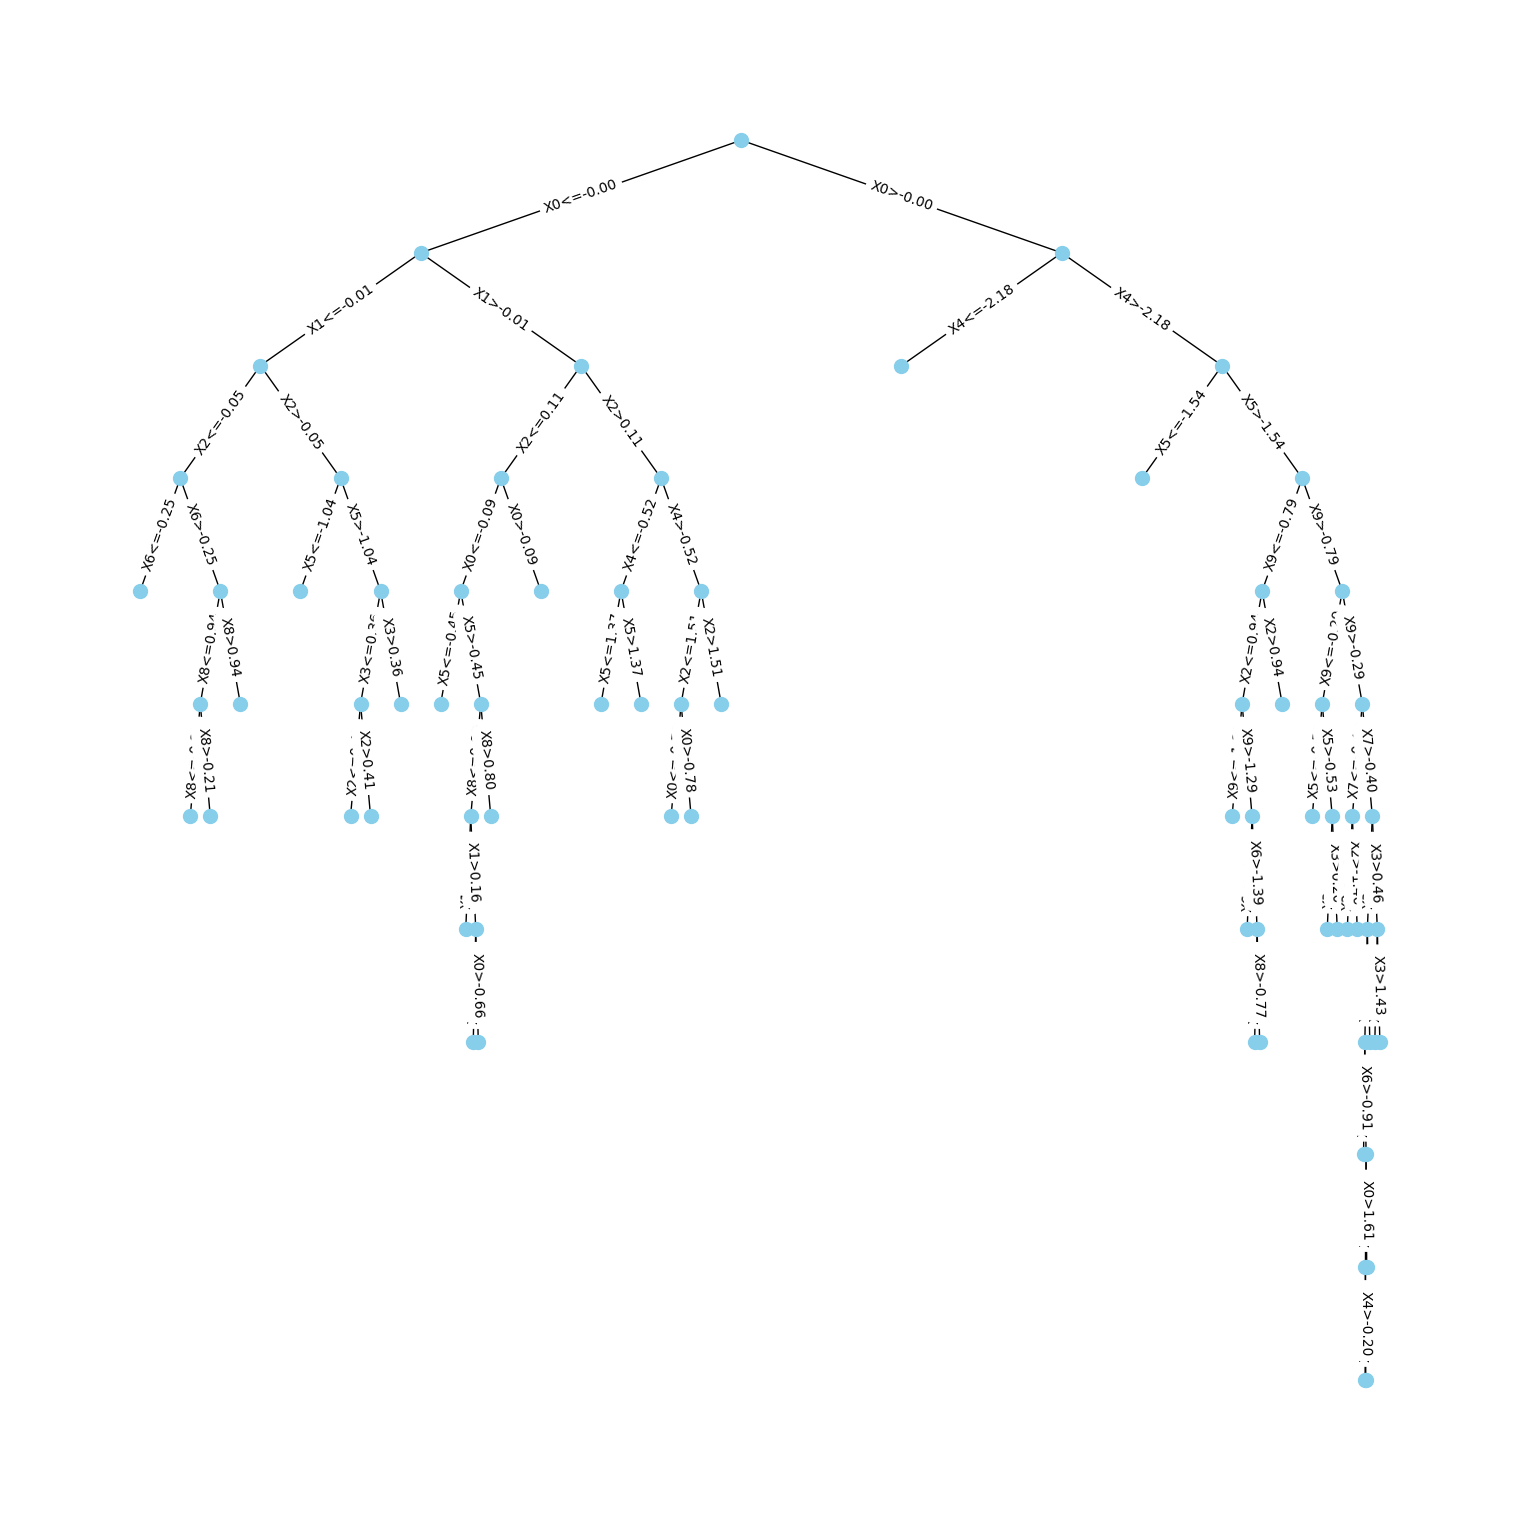

In [177]:
draw_tree(reg_tree.root)

In [180]:
# Create and train the regression tree
reg_tree_det = RegressionTree_(min_samples_split=10, max_depth=10)
reg_tree_det.fit(X, y)

# Make predictions
predictions = reg_tree_det.predict(X)

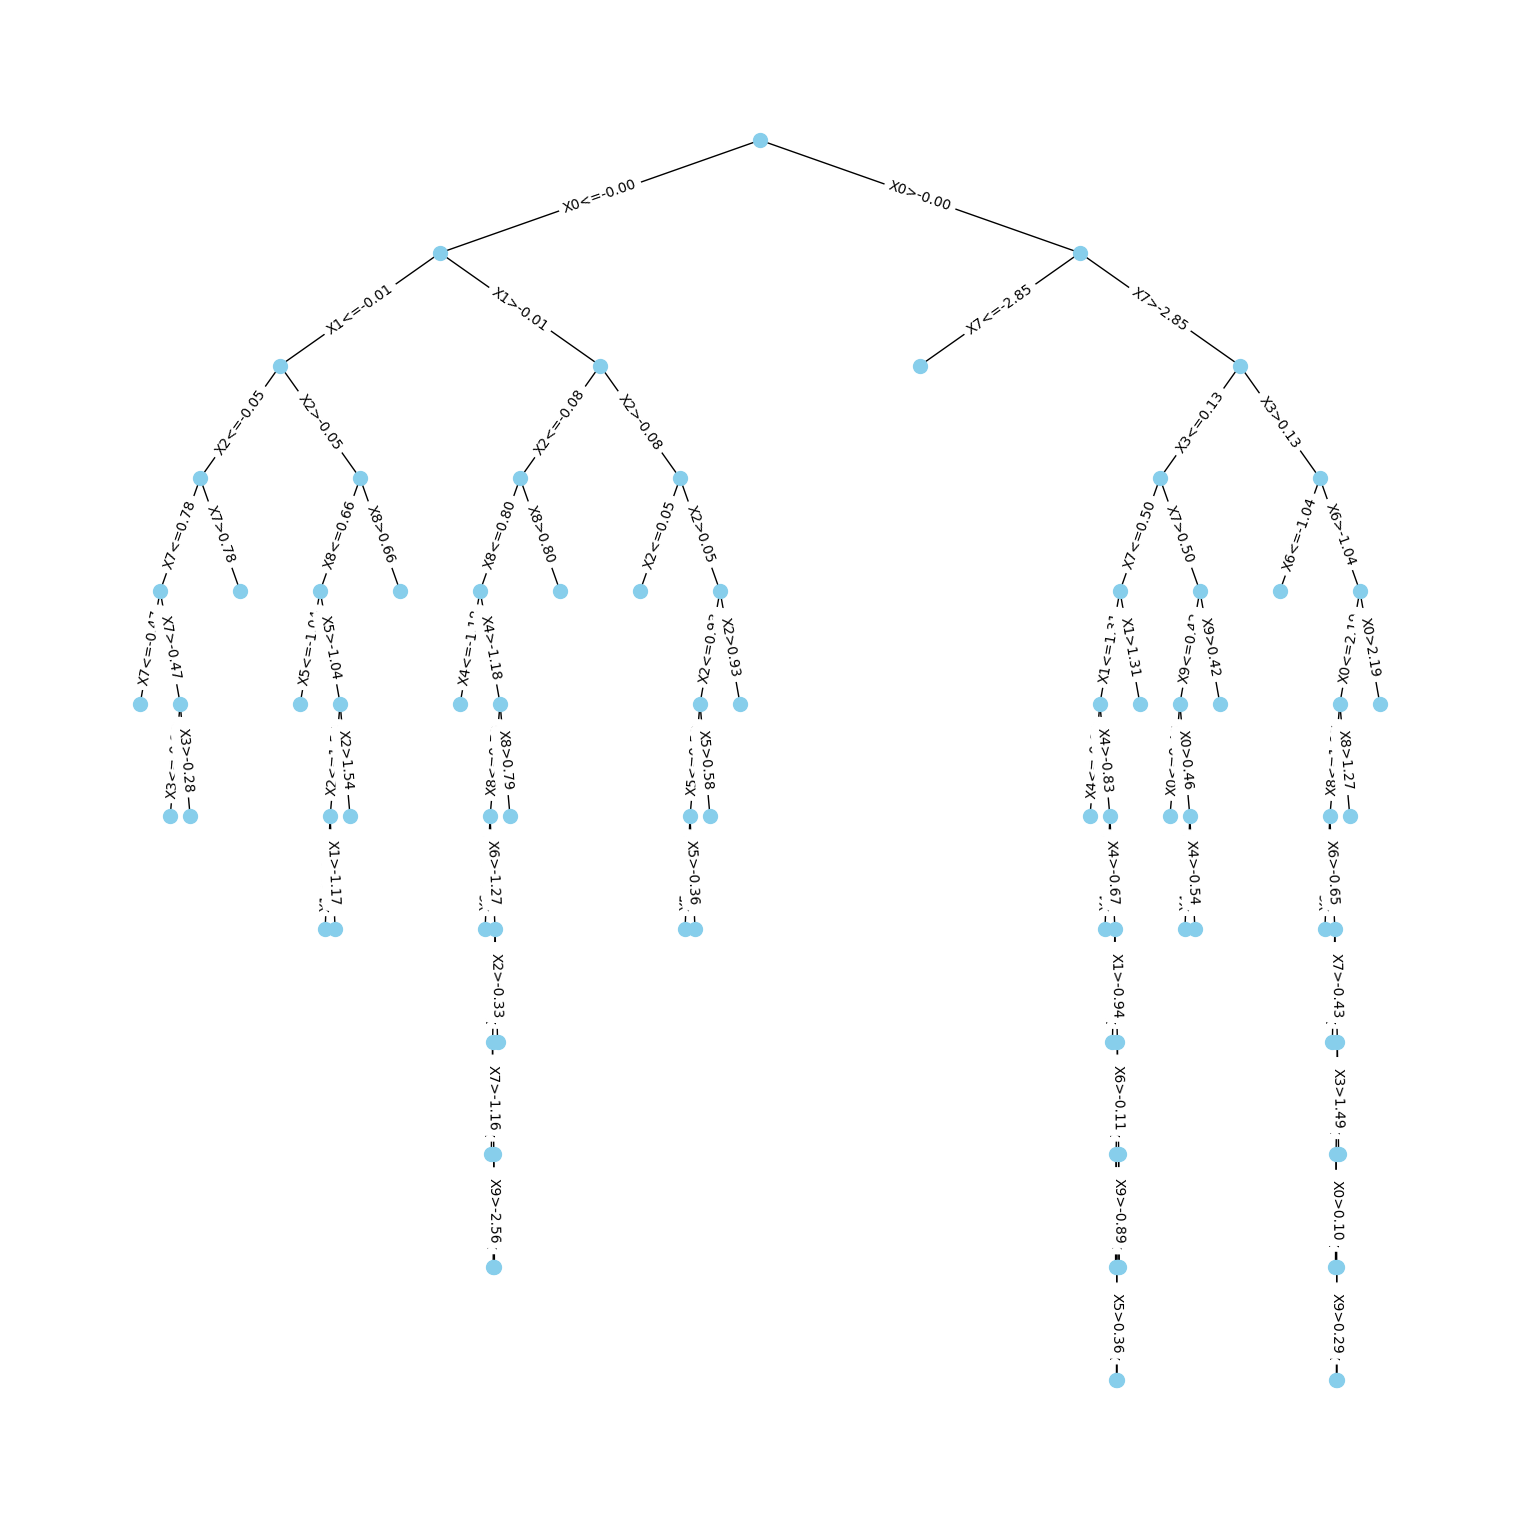

In [181]:
draw_tree(reg_tree_det.root)